In [16]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [23]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions


def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [15]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

####  The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be TRAINED.
For example, the input sequence “little girl running in field” would be split into 6 input-output pairs to train the model:
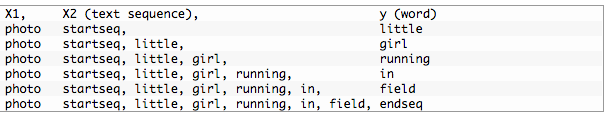

#### Later, when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

The function below named create_sequences(), given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1

In [26]:
# convert a dictionary of clean descriptions to a list of descriptions
def desc_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

listOfDesc = desc_to_list(train_descriptions)
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)



# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)


# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)
max_length = max_length(train_descriptions) #to be used later
print('Description Length', max_length)

#Longest desc check
def longest_desc(desc_list):
    max_length=max([len(item.split()) for item in desc_list])
    print("Max_len:",max_length)
    print("Desc:", [item for item in desc_list if len(item.split())==max_length])

longest_desc(listOfDesc)


Vocabulary Size: 7579
Description Length 34
Max_len: 34
Desc: ['startseq an africanamerican man wearing green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on busy sidewalk in front of group of men playing instruments endseq']


## MODEL 
### The model has been developed in the following three parts :
##### Photo Feature Extractor.
This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input. The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo
##### Sequence Processor. 
This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer. The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.
##### Decoder (for lack of a better name)
Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction. Both the input models produce a 256 element vector. The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

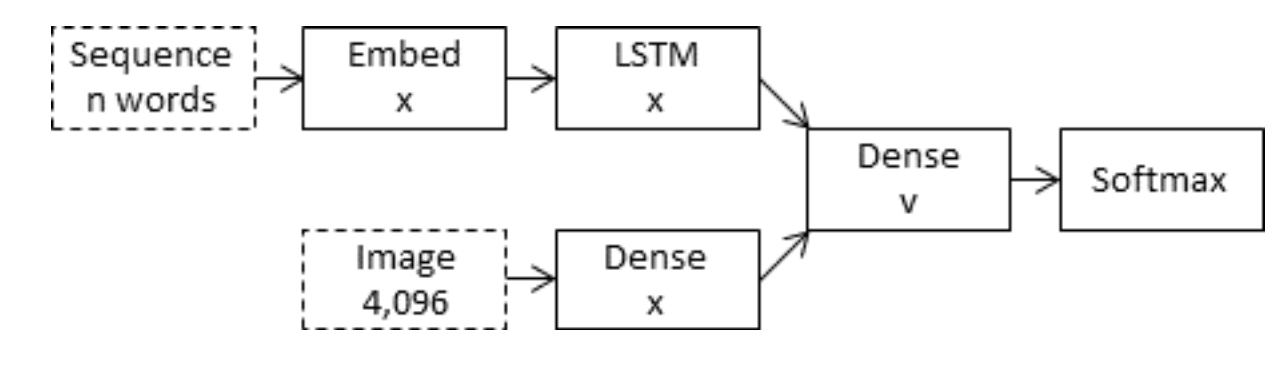

In [28]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 